In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

vol_file = Path('analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

## This analysis tries to reproduce TK's calcium results

In [3]:
from utils import *

### Find example neurons

In [4]:
k_ = boxcarKernel(sigma=60)
spk_cell_list = []
norm_cell_list = []
spk_mem_cell_list = []
n_row = -1
for _, row in dat_xls_file.iterrows():
    n_row+=1
    folder = row['folder']
    fish = row['fish']
    if 'memory' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    # spk with padding zeros for the first 2 seconds
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    
    mem_ind = frame_stimParams[2]==3;
    mem_ind = np.where(np.diff(mem_ind)==1)[0]

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    
    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1
    
    pre_swim_bout_index_task = swim_bout_index_task.copy()
    pre_ = np.where(pre_swim_bout_index_task==1)[0]
    for n_ in range(len(pre_)-1):
        pre_swim_bout_index_task[pre_[n_]:pre_[n_+1]] = pre_swim_bout_index_task[pre_[n_]:pre_[n_+1]] - pre_swim_bout_index_task[pre_[n_+1]-1]-1
    pre_swim_bout_index_task = -pre_swim_bout_index_task
    swim_bout_select = [0, 1, 2, 3, 4, 5, np.inf]
    
    for n_cell in range(spk.shape[0]):
        spk_list = np.zeros((r_swim.shape[0], 400))
        remove_list = np.zeros(r_swim.shape[0]).astype('bool')
        for n, n_swim in enumerate(swim_starts):
            try:
                spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300]
            except:
                remove_list[n]=True
        spk_list = spk_list[~remove_list, :]
        if spk.shape[-1]>frame_stimParams.shape[-1]:
            mean_act_ = spk[n_cell, :frame_stimParams.shape[-1]][frame_stimParams[2,:]==2].mean()*300
        else:
            mean_act_ = spk[n_cell, :][frame_stimParams[2,:spk.shape[-1]]==2].mean()*300
        norm_cell_list.append(mean_act_)
        ind = task_period[~remove_list]==3
        
        l_ = []
        for n_ in range(len(swim_bout_select)-1):
            ind = (task_period[~remove_list]==1) & (pre_swim_bout_index_task[~remove_list]>swim_bout_select[n_]) & (pre_swim_bout_index_task[~remove_list]<=swim_bout_select[n_+1])
            ave_ = spk_list[ind, :].mean(axis=0)*300
            ave_ = smooth(ave_, k_)
            # l_.append(ave_[:50].mean())
            # l_.append(np.percentile(ave_[:100], 80))
            l_.append(ave_[50:100].mean())
            l_.append(np.percentile(ave_[100:], 80))
            ind = (task_period[~remove_list]==2) & (swim_bout_index_task[~remove_list]>swim_bout_select[n_]) & (swim_bout_index_task[~remove_list]<=swim_bout_select[n_+1])
            ave_ = spk_list[ind, :].mean(axis=0)*300
            ave_ = smooth(ave_, k_)
            # l_.append(ave_[:50].mean())
            # l_.append(np.percentile(ave_[:50], 80))
            l_.append(ave_[50:100].mean())
            l_.append(np.percentile(ave_[50:], 80))
            
        mm_ = []
        for n_ in range(3):
            m_ = []
            for n_mem in mem_ind:
                m_.append(spk[n_cell, n_mem+n_*900:n_mem+(n_+1)*900].mean()*300)
            mm_.append(np.array(m_).mean())
        spk_mem_cell_list.append(mm_)
        
        spk_cell_list.append(l_)

 number of cell 0.7780979827089337


/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


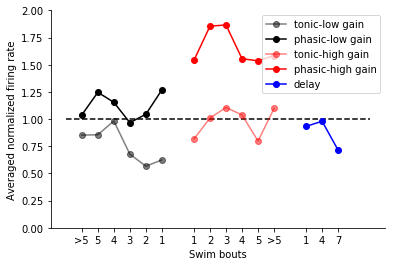

In [13]:
xticks = ['1', '2', '3', '4', '5', '>5']
xticks = list(reversed(xticks)) + xticks
xticks = xticks + ['1', '4', '7']
norm_cell_spk = 0.10
x_r = len(swim_bout_select)-1
spk_cell_list_ = np.array(spk_cell_list)
norm_cell_list = np.array(norm_cell_list)
spk_cell_list_ = spk_cell_list_/norm_cell_list[:, np.newaxis]
spk_mem_cell_list_ = spk_mem_cell_list/norm_cell_list[:, np.newaxis]
val_cell = ((spk_cell_list_[:, 0::4]<1).sum(axis=-1)>2) & (norm_cell_list>norm_cell_spk) #& (spk_mem_cell_list_[:, 0]>0)
spk_cell_list_ = spk_cell_list_[val_cell]
spk_mem_cell_list_ = spk_mem_cell_list_[val_cell]
print(f' number of cell {val_cell.mean()/(norm_cell_list>norm_cell_spk).mean()}')
plt.plot(np.arange(0, -x_r, -1)-1, np.nanmean(spk_cell_list_[:, 0::4], axis=0), '-ok', alpha=0.5, label='tonic-low gain')
plt.plot(np.arange(0, -x_r, -1)-1, np.nanmean(spk_cell_list_[:, 1::4], axis=0), '-ok', label='phasic-low gain')
plt.plot(np.arange(1, x_r+1), np.nanmean(spk_cell_list_[:, 2::4], axis=0), '-or', alpha=0.5, label='tonic-high gain')
plt.plot(np.arange(1, x_r+1), np.nanmean(spk_cell_list_[:, 3::4], axis=0), '-or', label='phasic-high gain')
plt.plot(np.arange(x_r+2, x_r+5), np.nanmean(spk_mem_cell_list_, axis=0), '-ob', label='delay')
plt.ylabel('Averaged normalized firing rate')
plt.xlabel('Swim bouts')
plt.hlines([1.0], [-x_r-1], [x_r+6], linestyles= '--')
plt.xticks(np.r_[(np.arange(-x_r, 0), np.arange(1, x_r+1), np.arange(x_r+2, x_r+5))], xticks)
plt.legend()
plt.ylim([0, 2])
sns.despine()
plt.show()

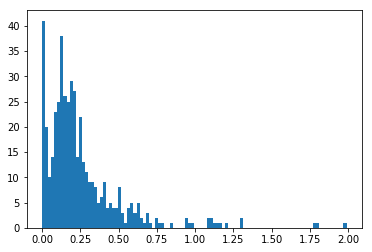

In [86]:
plt.hist(norm_cell_list, bins=100)
plt.show()

In [14]:
n_task = task_period.max().astype('int')
swim_task_index_ = (swim_task_index-1)%n_task+1
swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
swim_bout_index_task[0] = 1
for n_bout in range(len(swim_task_index_)-1):
    if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
        swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
    else:
        swim_bout_index_task[n_bout] = 1

swim_bout_index_task = swim_bout_index_task

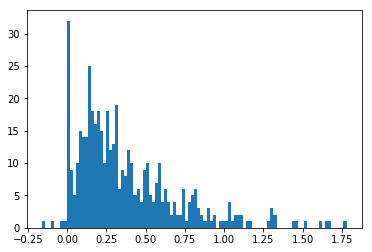

In [111]:
plt.hist(spk_cell_list, bins=100)
plt.show()

### plot example neurons

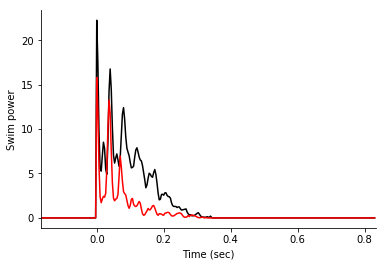

In [216]:
nfish = 1
ncell_ = 19
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
# print(f'Processing {folder} {fish}')
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
num_cell = spk.shape[0]
# spk with padding zeros for the first 2 seconds
spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

_ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

p_swim = np.sqrt(r_swim**2+l_swim**2)

plt.plot(np.arange(300)/300-50/300, p_swim[task_period==1, :].mean(axis=0), '-k')
plt.plot(np.arange(300)/300-50/300, p_swim[task_period==2, :].mean(axis=0), '-r')
plt.ylabel('Swim power')
plt.xlabel('Time (sec)')
plt.xlim([-50/300, 250/300])
# plt.ylim([0, 160])
# plt.vlines([0], [0], [320], colors='k', linestyles='--')
sns.despine()
plt.show()

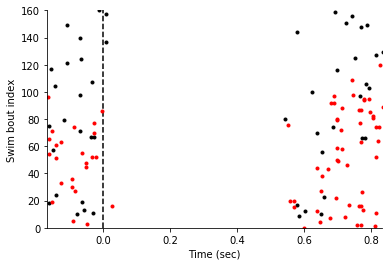

In [217]:
spk_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300] 
        except:
            pass
    plt_raster(spk_list[task_period==1, :], c='k')
    plt_raster(spk_list[task_period==2, :], c='r')
    # plt.title(f'Cell #{n_cell}')
    plt.ylabel('Swim bout index')
    plt.xlabel('Time (sec)')
    plt.xlim([-50/300, 250/300])
    plt.ylim([0, 160])
    plt.vlines([0], [0], [320], colors='k', linestyles='--')
    sns.despine()
    plt.show()

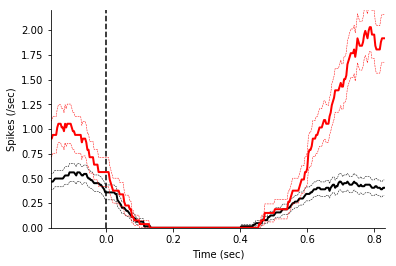

In [218]:
# k_ = gaussKernel(sigma=20)
k_ = boxcarKernel(sigma=60)
# ave_ = spk_list[task_period==1, :].mean(axis=0)*300
ave_ = []
for n_spk in spk_list[task_period==1, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-k', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--k', lw=0.5)


ave_ = []
for n_spk in spk_list[task_period==2, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-r', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--r', lw=0.5)

plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [0], [2.2], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()

In [219]:
from scipy.signal import medfilt

subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

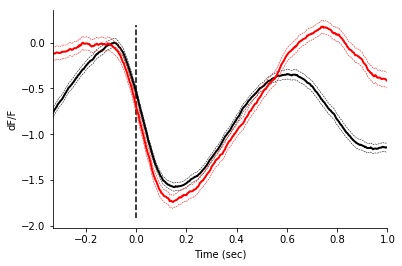

In [220]:
sub_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
        except:
            pass

t_min = 0
t_max = 400
ave_ = sub_list[task_period==1, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[:(100-t_min)].max()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-k', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--k', lw=0.5)

ave_ = sub_list[task_period==2, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[:(100-t_min)].max()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-r', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--r', lw=0.5)

# plt.ylim([0, 2.2])
plt.xlim([-(100-t_min)/300, (t_max-100)/300])
plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('dF/F')
sns.despine()

In [ ]:


swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]
swim_ends   = swim_ends[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
swim_starts = swim_starts[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
task_period = frame_stimParams[2,swim_starts]
task_index  = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
swim_task_index = task_index[swim_starts]
swim_count  = np.zeros((len(swim_starts),))